# The Peaking Power-Plants

## Motivation

You are the boss of an electricity distribution company. Based on the contracts with the end-users, you know the demand on the amount of the electrical energy between hour $t$ and $(t+1)$ next day; i.e., you have vector $\bar{d} = (d_0, d_1, \dots, d_{23})$ of demands.

Your company owns several power-plants and wants to cover the demands by switching these plants on and off. There are two types of power-plants: `base` and `peak` plants (there are $n_{base}$ and $n_{peak}$ of these plants).

* **Base power-plants** (zdroje základního zatížení) are cheap, but it takes a long time to start them and turn them off; therefore, they need to be either turned on or turned off the whole day. These plants produce $e_{base}$ energy every hour and their running cost is $c_{base}$ every hour.
    
* **Peak power-plants** (špičkové zdroje) are fast, and can be turned on/off every hour, but typically the price is high. These plants produce $e_{peak}$ energy every hour and their running cost $c_{peak}$ (every hour).


The surplus energy is being stored in the batteries (storage) and can be used later. However, there is a loss modeled by parameter $\gamma \in [0,1]$. If $k$ units of energy leave the storage, only $\gamma \cdot k$ units can be used to cover demands (the rest, i.e., $(1-\gamma)\cdot k$, is lost).

The capacity of the storage is limited to $s_{max}$ units, and due to technological restrictions, it is impossible to take the energy from the storage and store it inside simultaneously. The produced energy needs to cover the demands or be stored in the batteries (energy cannot just vanish). The storage is empty at the beginning.

You want to minimize to total cost (turning the power-plants on/off) while covering all the demands.

## Input

You are given the following:

* $T$ – the number of hours to be considered
* $\mathbf{d} = (d_0,d_1,\dots,d_{23})$ – vector of demands
* $n_{base},n_{peak}$ – number of the respective power-plants
* $c_{base}, c_{peak}$ – cost needed for the running of the respective type of the plant (per hour)
* $e_{base}, e_{peak}$ – amount of energy generated by the respective type (per hour)
* $s_{max}$ – storage capacity
* $(1−\gamma)$ – energy loss of the storage (only $\gamma \cdot k$ energy units can be used out of $k$ units)

For the testing purposes, you can experiment with the following instance:

In [1]:
d = [5, 5, 5, 5, 5, 10, 10, 15, 20, 20, 30, 30, 40, 50, 60, 60, 60, 50, 40, 30, 30, 20, 10, 5]
T = len(d)

n_base = 3
e_base = 7
c_base = 2.0 / 24.0

n_peak = 40
e_peak = 2
c_peak = 12

s_max = 100

gamma = 0.75

## Output

Your goal is to find the number of `base` power-plants that should be active throughout the whole day, as well as the number of `peak` power-plants that should be active every hour such that the cost is minimized.

## Exercise

Implement the ILP modelfor the peaking power-plants problem, solve it and examine the solution.

In [2]:
import gurobipy as gb

# MODEL
m = gb.Model()

# - ADD VARIABLES
# The number of running base load power-plants.
base = m.addVar(0, n_base, 0, gb.GRB.INTEGER);

# How many peaking power-plants are running in each hour.
peak = [m.addVar(0, n_peak, 0, gb.GRB.INTEGER) for t in range(T)]

# Energy storage state in each hour.
s = [m.addVar(0, s_max, 0, gb.GRB.CONTINUOUS) for t in range(T+1)]

# Amount of energy taken from the storage.
a_take = [m.addVar(0, gb.GRB.INFINITY, 0, gb.GRB.CONTINUOUS) for t in range(T)]

# Amount of energy put into the storage.
a_put = [m.addVar(0, gb.GRB.INFINITY, 0, gb.GRB.CONTINUOUS) for t in range(T)]

# Whether we are putting or taking from the storage.
y = [m.addVar(0, 1, 0, gb.GRB.INTEGER) for t in range(T)]

# Amount of generated energy.
g = [m.addVar(0, gb.GRB.INFINITY, 0, gb.GRB.CONTINUOUS) for t in range(T)]

# - ADD CONSTRAINTS
for t in range(T):
    # Generated energy is obtained from the peak and base power-plants.
    m.addConstr(e_base * base + e_peak * peak[t] == g[t])

for t in range(T):
    # Demand is exactly covered by the generated energy, plus the energy taken from the storage;
    # the remaining energy is stored.
    m.addConstr(g[t] + gamma * a_take[t] - a_put[t] == d[t])

m.addConstr(s[0] == 0)
for t in range(T):
    # Model the energy inside the storage.
    m.addConstr(s[t + 1] == (s[t] - a_take[t]) + a_put[t])

big_m = s_max
for t in range(T):
    # Decide whether enegy is put or taken into/from the storage; use 'big M' trick.
    m.addConstr(big_m * (1 - y[t]) >= a_take[t])
    m.addConstr(big_m * y[t] >= a_put[t])

# - SET OBJECTIVE
# Minimize the cost for activating the power-plants.
m.setObjective(24 * c_base * base + gb.quicksum([c_peak * peak[t] for t in range(T)]), gb.GRB.MINIMIZE)

m.optimize()

Academic license - for non-commercial use only
Optimize a model with 121 rows, 146 columns and 337 nonzeros
Variable types: 97 continuous, 49 integer (0 binary)
Coefficient statistics:
  Matrix range     [8e-01, 1e+02]
  Objective range  [2e+00, 1e+01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [5e+00, 1e+02]
Presolve removed 28 rows and 28 columns
Presolve time: 0.00s
Presolved: 93 rows, 118 columns, 279 nonzeros
Variable types: 69 continuous, 49 integer (23 binary)
Found heuristic solution: objective 3708.0000000

Root relaxation: objective 1.050000e+03, 69 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1050.00000    0   12 3708.00000 1050.00000  71.7%     -    0s
H    0     0                    3014.0000000 1050.00000  65.2%     -    0s
H    0     0                    1972.0000000 1050.00000  46.8%     -    0s
     0     0 1114.4526

## Solution visualization

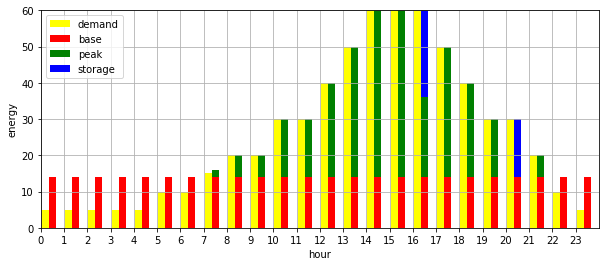

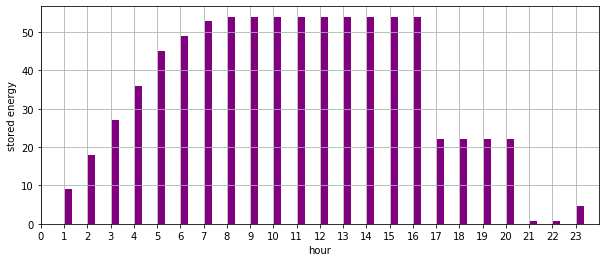

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_demands(n_base, n_peak_every_hour, storage_take_every_hour, storage_state_every_hour):
    """
    n_base: number of active base power-plants
    n_peak_every_hour: a list containing the number of active peak power-plants (every hour)
    storage_take_every_hour: a list containing the amount of energy, which is taken from the storage (every hour)
    storage_state_every_hour: a list containing the amount of energy, which is stored in the storage (every hour)
    """
    # Demand plot
    margin = 0.2
    width = 0.3
    plt.figure(figsize=(10, 4))
    plt.bar([t + margin for t in range(T)], d, width=width, color='yellow')
    
    # - base power-plants
    bottom = np.zeros(T)
    g_base = np.array([e_base * n_base for t in range(T)])
    plt.bar([t + margin + width for t in range(T)],
            g_base,
            width=width,
            bottom=bottom,
            color='red')
    bottom += g_base
    
    # - peak power-plants
    g_peak = np.array([e_peak * n_peak_every_hour[t] for t in range(T)])
    plt.bar([t + margin + width for t in range(T)],
            g_peak,
            width=width,
            bottom=bottom,
            color='green')
    bottom += g_peak
    
    # - storage
    g_a_take = np.array([gamma * storage_take_every_hour[t] for t in range(T)])
    plt.bar([t + margin + width for t in range(T)],
            g_a_take,
            width=width,
            bottom=bottom,
            color='blue')
    bottom += g_a_take

    plt.xlabel("hour")
    plt.ylabel("energy")
    plt.legend(['demand', 'base', 'peak', 'storage'], ncol=1, loc=2)
    #plt.legend(['demand', 'base', 'peak'], ncol=1, loc=2)
    plt.xlim(0, 24)    
    plt.xticks(range(24), [i % 24 for i in range(24)])
    plt.grid()    

    # Storage plot.
    plt.figure(figsize=(10, 4))
    plt.xlim(0, 24)
    plt.xticks(range(24), [i % 24 for i in range(24)])
    plt.xlabel("hour")
    plt.ylabel("stored energy")    
    plt.bar([t + margin for t in range(T)], [storage_state_every_hour[t] for t in range(T)], width=width, color='purple')
    plt.grid()    

    plt.show()
    
# Call this function with 
# - the number of base power-plants to be activated,
# - list of the numbers of the peak power-plants to be activated (every hour),
# - list containing the amount of power taken from the storage (every hour),
# - list containing the amount of energy in the storage (every hour)
plot_demands(base.x, [peak[t].x for t in range(T)], [a_take[t].x for t in range(T)], [s[t].x for t in range(T)])